# Movie Recommendations
## CapStone 8
### EDA

In [ ]:
import sys
print(sys.executable)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

d:\VSCodePrograms\CapStone\CapStone8\.venv\Scripts\python.exe


Converting txt to csv file as it provides a standard, easily parsed format for analysis.

In [ ]:
dataMovies = pd.read_csv('movies.txt')
dataMovies.to_csv('dataMovies.csv', index=False)
dataRatings = pd.read_csv('ratings.txt')
dataRatings.to_csv('dataRatings.csv', index=False)

: 

In [ ]:
print("Display Data head:")
print(dataMovies.head())
dfMovies = pd.DataFrame(dataMovies)

Display Data head:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


: 

In [ ]:
print("Display Data head:")
print(dataRatings.head())
dfRatings = pd.DataFrame(dataRatings)

Display Data head:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


: 

In [ ]:
dfMovies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


: 

In [ ]:
dfRatings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


: 

| Column Name | Type        | Subtype                 | Notes                                                                                                                         |
| ----------- | ----------- | ----------------------- | ----------------------------------------------------------------------------------------------------------------------------- |
| `userId`    | Categorical | Nominal (Discrete ID)   | Unique identifier for a user.         |
| `movieId`   | Categorical | Nominal (Discrete ID)   | Unique identifier for a movie.
| `rating`    | Numerical   | Ordinal / Discrete      | User’s rating of a movie.
| `timestamp` | Numerical   | Continuous (Time-based) | timestamp representing when the rating was given.

| Column Name | Type        | Subtype               | Notes                              |
|-------------|-------------|------------------------|--------------------------------------|
| `movieId`   | Categorical | Nominal (Discrete ID) | Unique movie identifier.             |
| `title`     | Categorical | Nominal               | Movie title                          |
| `genres`    | Categorical | Nominal (Multi-label) | Pipe-separated list of genres        |

Together looking at the dataset at a high level we can tell the Movies and Ratings datasets form a user item interaction dataset, which is used for recommendation systems and behavior analysis rather than traditional prediction problems.</br>
Instantly you can tell there's a lot you can do with this dataset, starting with organizing the genres, and checking ratings and seeing which genre is the best, and much much more.

In [ ]:
dfMovies.isna().sum()
dfmovies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

: 

In [ ]:
dfRatings.isna().sum()
dfRatings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

: 

Good thing there's no null values to deal with here.</br>
Since timestamp has values we can utilize and get deeper into our EDA I have decided to expand the timestamp for more thorough analysis, early on.

In [ ]:
dfRatings["timestamp"] = pd.to_datetime(dfRatings["timestamp"], unit="s")
dfRatings["timestampYear"] = dfRatings["timestamp"].dt.year
dfRatings["timestampMonth"] = dfRatings["timestamp"].dt.month
dfRatings["timestampDay"] = dfRatings["timestamp"].dt.day
dfRatings["timestampDayOfWeek"] = dfRatings["timestamp"].dt.dayofweek
dfRatings["timestampHour"] = dfRatings["timestamp"].dt.hour
dfRatings["timestampDayName"] = dfRatings["timestamp"].dt.day_name()
dfRatings.head()

,userId,movieId,rating,timestamp,timestampYear,timestampMonth,timestampDay,timestampDayOfWeek,timestampHour,timestampDayName
0,1,1,4.0,2000-07-30 18:45:03,2000,7,30,6,18,Sunday
1,1,3,4.0,2000-07-30 18:20:47,2000,7,30,6,18,Sunday
2,1,6,4.0,2000-07-30 18:37:04,2000,7,30,6,18,Sunday
3,1,47,5.0,2000-07-30 19:03:35,2000,7,30,6,19,Sunday
4,1,50,5.0,2000-07-30 18:48:51,2000,7,30,6,18,Sunday


: 

#### Rating Distribution

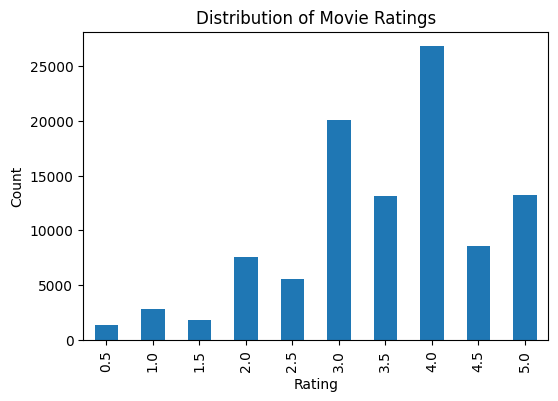

: 

In [ ]:
plt.figure(figsize=(6,4))
dfRatings["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


The rating distribution is positively skewed, with most ratings concentrated between 3.0 and 5.0. This indicates a positivity bias, where users are more likely to rate movies they enjoyed. Low ratings are relatively rare, suggesting selective user engagement rather than neutral. Which is totally understandable.

#### Ratings Over Time

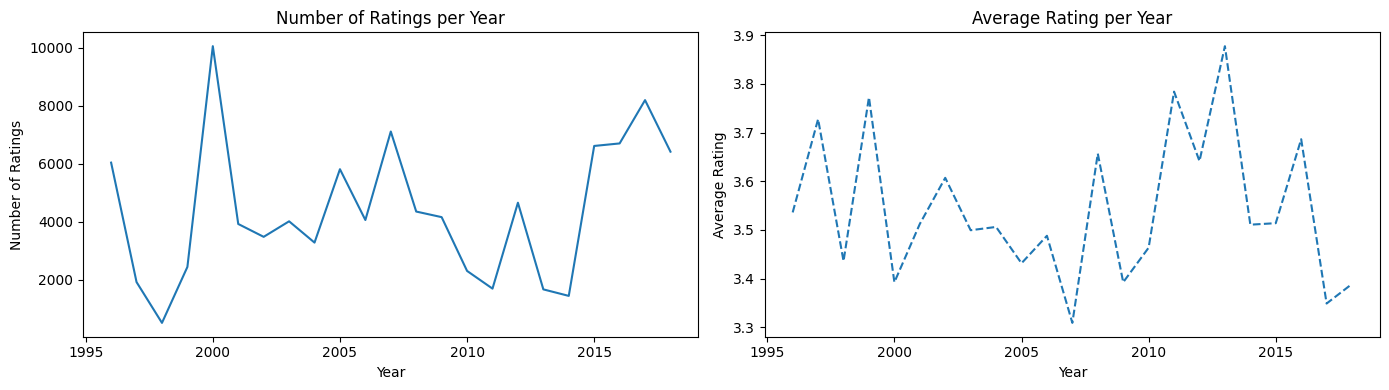

: 

In [ ]:
ratings_per_year = dfRatings.groupby("timestampYear").size()
avg_rating_year = dfRatings.groupby("timestampYear")["rating"].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

# Plot 1: Number of Ratings per Year
axes[0].plot(ratings_per_year)
axes[0].set_title("Number of Ratings per Year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of Ratings")

# Plot 2: Average Rating per Year
axes[1].plot(avg_rating_year, linestyle="--")
axes[1].set_title("Average Rating per Year")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Average Rating")

plt.tight_layout()
plt.show()


The number of ratings varies significantly by year, showing sharp spikes and declines rather than a steady trend. An early surge around 2000 is followed by a period of reduced activity, with a notable recovery after 2014. This suggests fluctuating user engagement over time, could possible be influenced by platform growth and data collection patterns.

#### Day of Week Behavior

In [ ]:
ordered_days = [
    "Monday", "Tuesday", "Wednesday",
    "Thursday", "Friday", "Saturday", "Sunday"
]

dayname_counts = (
    dfRatings["timestampDayName"]
    .value_counts()
    .reindex(ordered_days)
)

: 

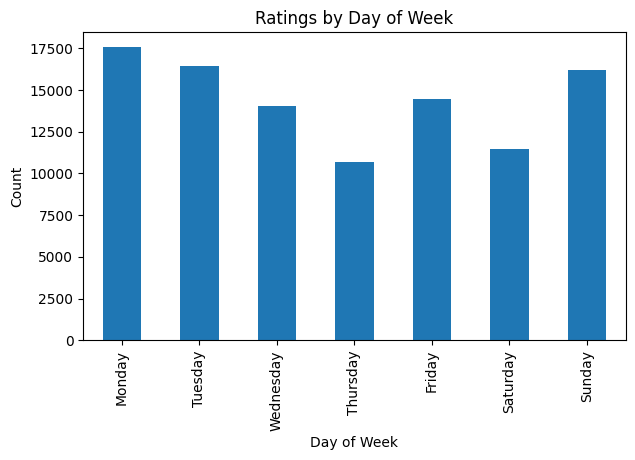

: 

In [ ]:

plt.figure(figsize=(7,4))
dayname_counts.plot(kind="bar")
plt.title("Ratings by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.show()


In order from highest to lowest.

#### Hourly Activity Pattern

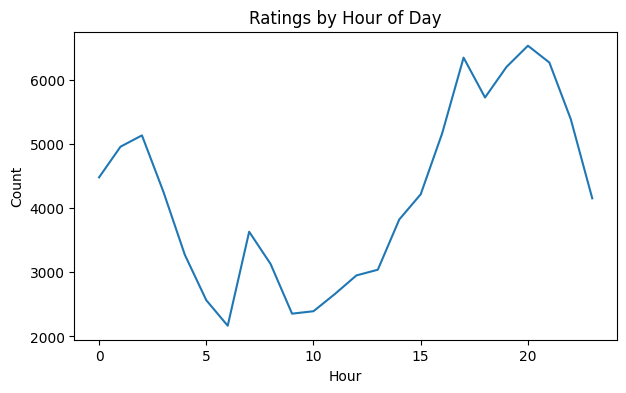

: 

In [ ]:
hour_counts = dfRatings.groupby("timestampHour").size()

plt.figure(figsize=(7,4))
hour_counts.plot()
plt.title("Ratings by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()


Ratings were usually made on the third quarter of the day, obviously after work hours.

#### Ratings vs Time (Behvaioral Depth) / User Activity Patterns

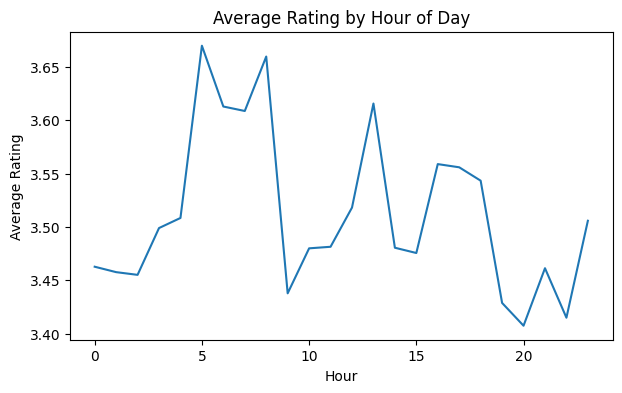

: 

In [ ]:
avg_rating_hour = dfRatings.groupby("timestampHour")["rating"].mean()

plt.figure(figsize=(7,4))
avg_rating_hour.plot()
plt.title("Average Rating by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Average Rating")
plt.show()


Average ratings remain relatively stable throughout the day, with only minor fluctuations. Slightly higher ratings appear in the early morning and midday hours, while late evening ratings tend to be marginally lower. Overall, time of day has a `limited impact` on rating sentiment.


#### Genre-based insights

In [ ]:
dfMerged = dfRatings.merge(dfMovies, on="movieId", how="left")


: 

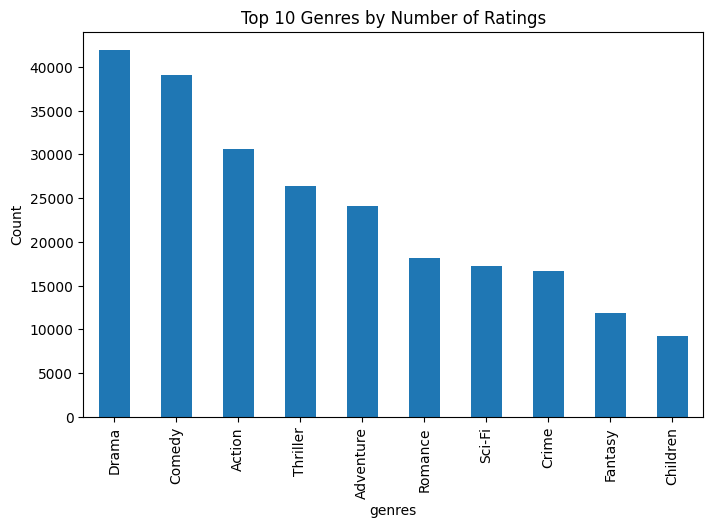

: 

In [ ]:
genre_counts = (
    dfMerged["genres"]
    .str.split("|")
    .explode()
    .value_counts()
)

plt.figure(figsize=(8,5))
genre_counts.head(10).plot(kind="bar")
plt.title("Top 10 Genres by Number of Ratings")
plt.ylabel("Count")
plt.show()


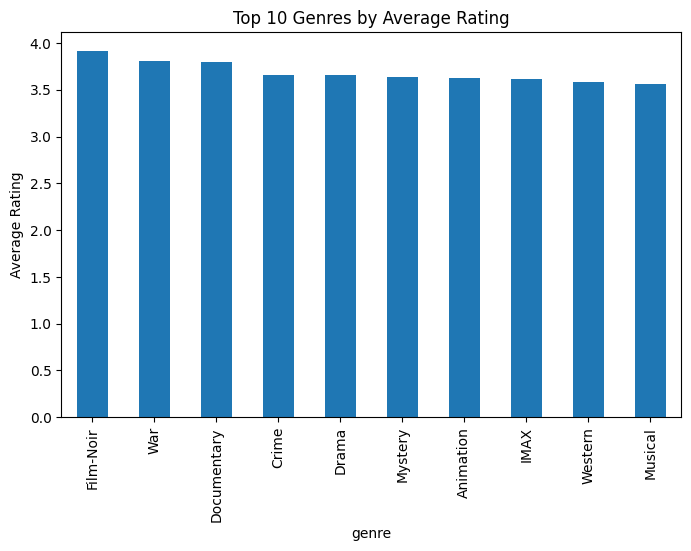

: 

In [ ]:
avg_genre_rating = (
    dfMerged.assign(genre=dfMerged["genres"].str.split("|"))
    .explode("genre")
    .groupby("genre")["rating"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,5))
avg_genre_rating.head(10).plot(kind="bar")
plt.title("Top 10 Genres by Average Rating")
plt.ylabel("Average Rating")
plt.show()


### Data Wrangling and Feature Engineering